## Task 2: train a PINN to invert for underlying parameters

#### Task

The second task is to use a PINN to **invert** for underlying parameters.

#### Approach

Similar to above, the PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

The key idea here is to also treat $\mu$ as a **learnable parameter** when training the PINN - so that we both simulate the solution and invert for this parameter.

In [1]:
#The important packages for this problem: 

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def Time_Independent_Schrodinger(a, n, x):
    """
    Defines the analytical solution to the time independent 1D Schrodinger equation problem. 
    Parameters: a = Length of box
                n = Energy state, ie n=1 is the ground state, n=2 is the first excited state,...
                x = Position   
    """
    
    pi= np.pi
    psi = np.sqrt(2/a) * np.sin( (n* pi * x) / a) 
    
    return psi

In [3]:
class FCN_GELU(nn.Module):
    "Defines a fully connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [4]:
#Function that plots the evolution of the loss function(s) over the iterations

def plot_losses(losses1,losses2=None,losses3=None,losses4=None,lossestot=None):
    plt.figure()
    plt.title("Loss over epoch")
    plt.plot(losses1,label="ML Loss")
    if None not in (losses2, losses3, losses4,lossestot):
        plt.plot(losses2,label="Dif Eq loss")
        plt.plot(losses3,label="Boundary 1 loss")
        plt.plot(losses4,label="Boundary 2 loss")
        plt.plot(lossestot,label="Total loss")
    
    plt.legend()
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.show()

True value of Energy: 19.739208802178716


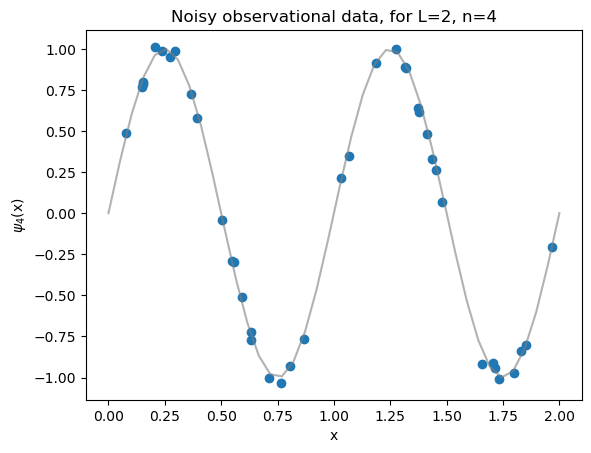

In [7]:
# first, create some noisy observational data
torch.manual_seed(123)
a, n = 2, 4

#set your constantes
hbar = 1 
m = 1

E = (n * np.pi * hbar) **2 / (2*m*a**2)

print(f"True value of Energy: {E}")


x_obs = a*torch.rand(40).view(-1,1)
y_obs = Time_Independent_Schrodinger(a, n, x_obs) + 0.04*torch.randn_like(x_obs)

plt.figure()
plt.title("Noisy observational data, for L=2, n=4")
plt.scatter(x_obs[:,0], y_obs[:,0])
x_test = torch.linspace(0,a,40).view(-1,1)
wave = Time_Independent_Schrodinger(a, n, x_test)
plt.plot(x_test[:,0], wave[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.xlabel("x")
plt.ylabel("$\psi_4$(x)")
plt.show()


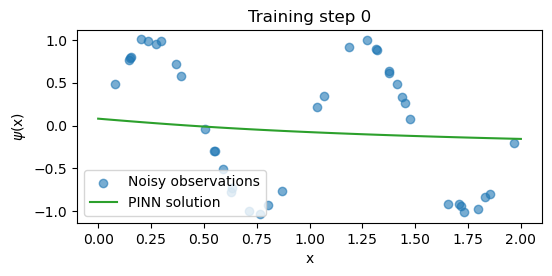

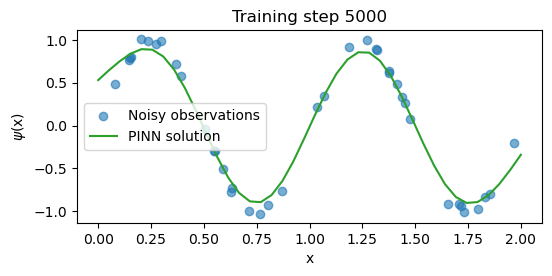

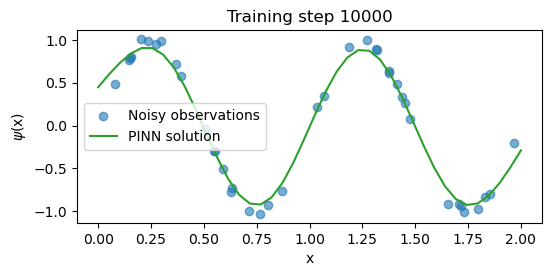

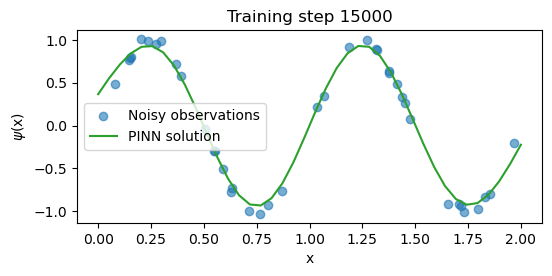

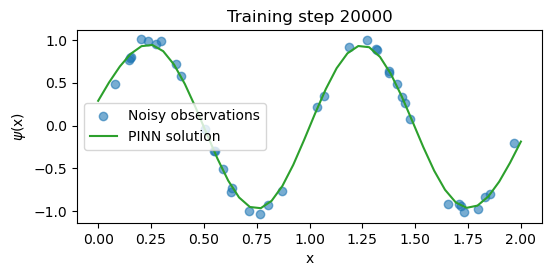

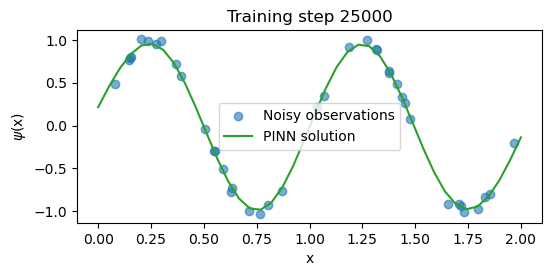

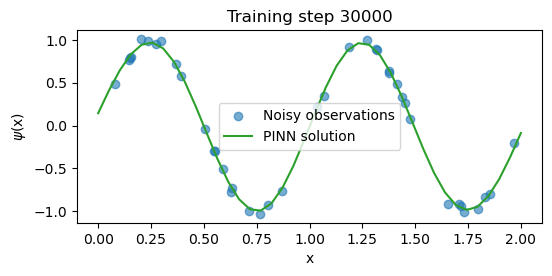

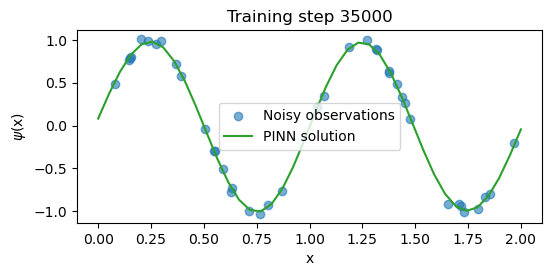

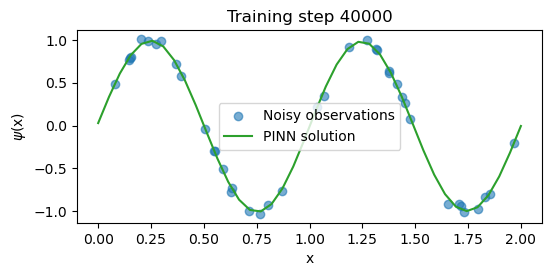

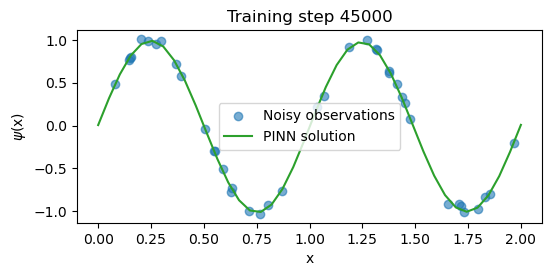

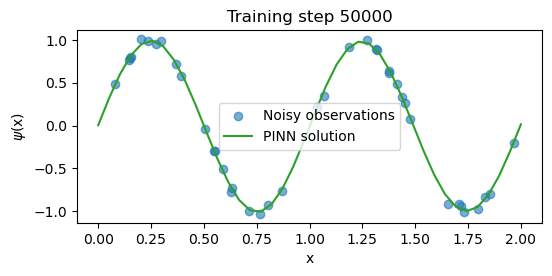

In [8]:
torch.manual_seed(123)

# define a neural network to train
model = FCN_GELU(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,a,30).view(-1,1).requires_grad_(True)

# treat k_squared as a learnable parameter
k_squared = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
k_squareds = []

# add k_squared to the optimiser
optimiser = torch.optim.Adam(list(model.parameters())+[k_squared],lr=1e-3)

# using the following hyperparameters:
lambda1 = 1e-4


losses = []


for i in range(50001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    
    # compute physics loss
    u = model(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + k_squared*u)**2)
    
    # compute data loss
    u = model(x_obs)
    loss2 = torch.mean((u - y_obs)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = lambda1*loss1 + loss2
    loss.backward()
    optimiser.step()
    
    # record mu value
    k_squareds.append(k_squared.item())

    losses.append(loss.detach())
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = model(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(x_obs[:,0], y_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.xlabel("x")
        plt.ylabel("$\psi$(x)")
        plt.legend()
        plt.show()

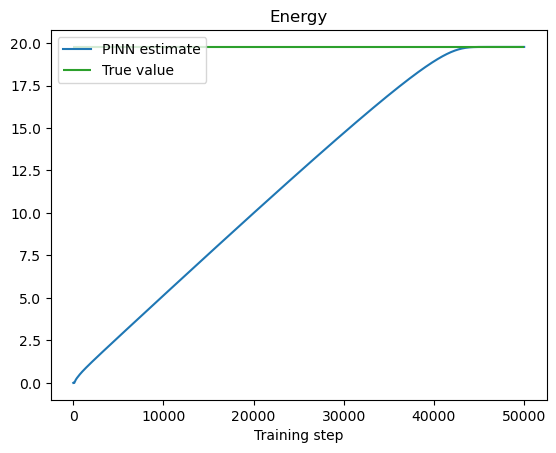

In [14]:
#Plot convergence of parameter: 

E_exp = ((np.array(k_squareds))*(hbar**2)) / (2 * m)

plt.figure()
plt.title("Energy")
plt.plot(E_exp, label="PINN estimate")
plt.hlines(E, 0, len(k_squareds), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

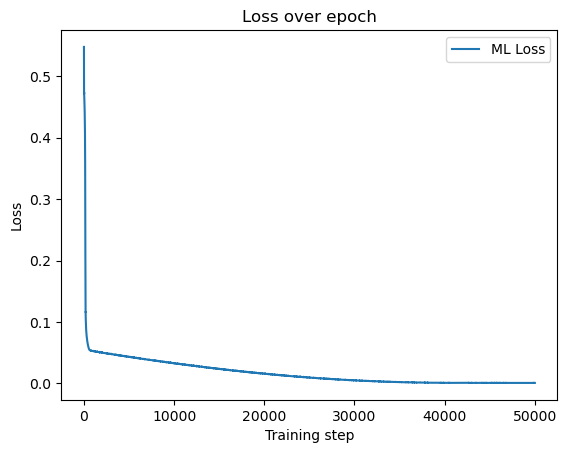

In [15]:
plot_losses(losses)

Converges really late...
However, loss function is not all that low!

lets take a differential equation as a* dx2+ b* dx+c*x=0
If we are inverting the problem for c, it seems that this parameter grows linearly until converging!

Let me try to do it without the physics loss function:

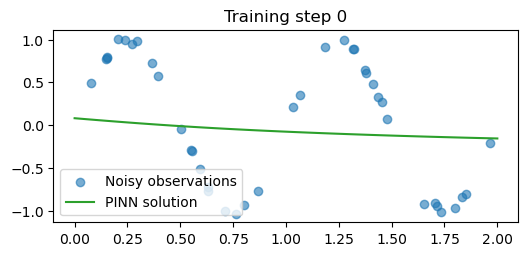

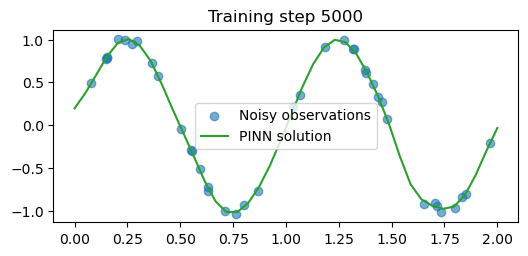

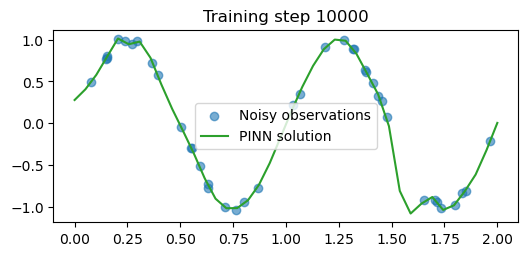

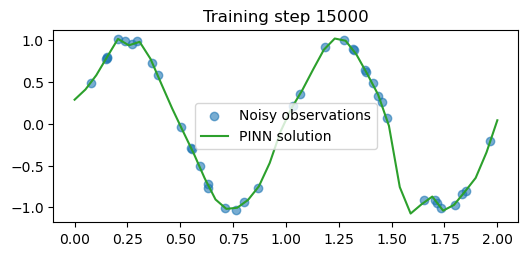

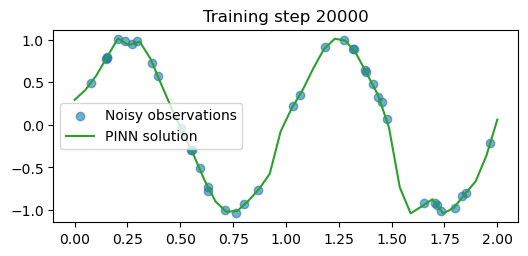

In [16]:
torch.manual_seed(123)

# define a neural network to train
model = FCN_GELU(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,a,30).view(-1,1).requires_grad_(True)

# treat k_squared as a learnable parameter
k_squared = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
k_squareds = []

# add k_squared to the optimiser
optimiser = torch.optim.Adam(list(model.parameters())+[k_squared],lr=1e-3)

# using the following hyperparameters:
lambda1 = 1e-4

for i in range(20001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    
    # compute physics loss
    u = model(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + k_squared*u)**2)
    
    # compute data loss
    u = model(x_obs)
    loss2 = torch.mean((u - y_obs)**2)
    
    # backpropagate joint loss, take optimiser step
    # loss = lambda1*loss1 + loss2
    loss = loss2
    loss.backward()
    optimiser.step()
    
    # record mu value
    k_squareds.append(k_squared.item())
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = model(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(x_obs[:,0], y_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

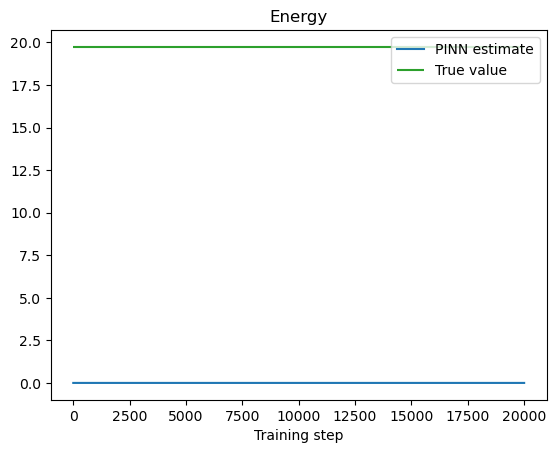

In [17]:
#Plot convergence of parameter: 

E_exp = ((np.array(k_squareds))*(hbar**2)) / (2 * m)

plt.figure()
plt.title("Energy")
plt.plot(E_exp, label="PINN estimate")
plt.hlines(E, 0, len(k_squareds), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

Without the physics loss term the results are clearly worse!

Lets see if python with a normal fit of the data can outperform PINNs:

In [4]:
from scipy.optimize import curve_fit
from scipy.integrate import odeint

tensor(5.4592)
The value of Energy is 0.65
The value of Energy is 0.65
The value of Energy is 0.65
The value of Energy is 0.6500000096857548
The value of Energy is 1.5705144264150142
The value of Energy is 1.5705144498175028
The value of Energy is 2.1267311323032434
The value of Energy is 2.1267311639940067
The value of Energy is 2.4221235679125477
The value of Energy is 2.4221236040050016
The value of Energy is 2.58364222626505
The value of Energy is 2.583642264764319
The value of Energy is 2.682701087540612
The value of Energy is 2.682701127515973
The value of Energy is 2.750154136748175
The value of Energy is 2.7501541777286653
The value of Energy is 2.7998829743571103
The value of Energy is 2.799883016078618
The value of Energy is 2.8388110373996533
The value of Energy is 2.8388110797012343
The value of Energy is 2.870761064979241
The value of Energy is 2.8707611077569144
The value of Energy is 2.8980022410933364
The value of Energy is 2.898002284276935
The value of Energy is 2.921

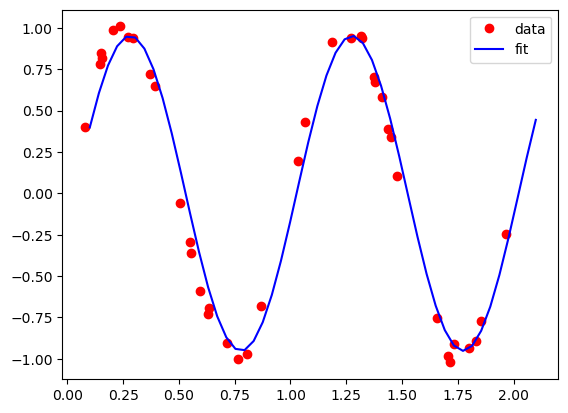

In [20]:
# given data we want to fit
#x_obs
#y_obs

#equation: y''(x) + k*y(x)= 0
#Turn into first order equation: 
# y'(x) = z(x)
# z'(x) = -k * y(x)

#I'll order x_obs, reshape it and generate the same wave but with y also organized and reshaped! 
x_obs_new = torch.sort(x_obs[:,0])[0]
y_obs_new = Time_Independent_Schrodinger(a, n, x_obs_new) + 0.04*torch.randn_like(x_obs_new)

slope = (y_obs_new[1]-y_obs_new[0]) / (x_obs_new[1]-x_obs_new[0])
print(slope)


def fitfunc(x, k):
    'Function that returns y computed from an ODE for a k'
    def myode(y, x):
        z1 = y[0] 
        z2 = y[1]
        dydt = [z2 , -k *z1]
        return dydt   
    y0 = [y_obs_new[0],slope] #Setting the initial condition (not sure what other initial condition I should give)
    y = odeint(myode, y0, x)
    print(f"The value of Energy is {k/2.}")
    return y[:,0]

##################################
#Curve fit
k_fit = curve_fit(fitfunc, x_obs_new, y_obs_new, p0=1.3)[0]

tfit = np.linspace(0,a);
fit = fitfunc(tfit, k_fit)

plt.plot(x_obs_new, y_obs_new, 'ro', label='data')
plt.plot(tfit + 0.1, fit, 'b-', label='fit')
plt.legend(loc='best');


Some thougths about this:
- I have to do a shift in the x axis, which is strange
- The approximation I am doing to the slope is not the best obviously the best. However, I found empirically that 5.5 works fine
- The values of Energy are not as similar to the true value as the PINNs are... however they do a good approximation way faster...

In [10]:
#taking 19.90720713 as the value the fit gives:

percentual_error = 100*(19.90720713 - E)/ E 
print(f"the percentual error is {percentual_error}")

the percentual error is 0.8510894712392978
